# BSD68 Dataset Denoising tramite Noise2Void

Questo Notebook descrive in modo strutturato le fasi di **addestramento** e **testing** di una Rete Neurale di tipo **U-Net** applicata al problema della **riduzione del rumore (denoising)** su immagini provenienti dal [Dataset BSD68](https://paperswithcode.com/dataset/bsd).

Il modello utilizza l’algoritmo **Noise2Void (N2V)**, nella sua implementazione fornita dalla libreria [CAREamics](https://careamics.github.io/0.1/).  
Noise2Void consente di apprendere un modello di denoising in modalità **autosupervisionata**, ovvero senza richiedere immagini pulite durante la fase di addestramento.

## Obiettivi del Notebook

Gli obiettivi principali dell’attività sono:

- Analizzare l’efficacia delle **Deep Neural Networks** nel contesto del denoising di immagini.
- Comprendere il funzionamento dell’algoritmo N2V e le sue caratteristiche principali.

## Il Dataset BSD68

Il **Dataset BSD68** è un benchmark ampiamente utilizzato nella letteratura scientifica per la valutazione di algoritmi di riduzione del rumore.  
È composto da **68 immagini in scala di grigi** che rappresentano una varietà di soggetti, tra cui:

- Scene naturali
- Animali
- Persone
- Oggetti di uso comune

Le immagini sono state **artificialmente degradate** mediante l’aggiunta di rumore con differenti livelli di intensità.  
A differenza di molti dataset reali, BSD68 fornisce anche le **Ground Truth**, ovvero le versioni pulite delle immagini, rendendo possibile una valutazione quantitativa delle prestazioni degli algoritmi.

## Motivazione dell’utilizzo di BSD68

In questo contesto, la presenza delle Ground Truth consente di:

- Valutare in modo oggettivo le prestazioni di Noise2Void.
- Analizzare i limiti di un approccio autosupervisionato anche in presenza di dati di riferimento.
- Fornire un confronto diretto tra immagini rumorose, immagini denoised e immagini originali.

In [1]:
import tifffile
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from careamics import CAREamist
from careamics.config import create_n2v_configuration
from careamics.utils.metrics import scale_invariant_psnr

sys.path.append('library')

import library.dataset as dataset


In [2]:

# Downlaod the Dataset
root_path = Path("notebooks/data/bsd68")
dataset.load_bsd68_dataset(root_path)

# The Dataset is already split into Training, Validation, Testing and Grand Truths
data_path = Path(root_path / "denoising-N2V_BSD68.unzip/BSD68_reproducibility_data")
train_path = data_path / "train"
val_path = data_path / "val"
test_path = data_path / "test" / "images"
gt_path = data_path / "test" / "gt"


Loading BSD68 Dataset
BSD68 Dataset Loaded at notebooks/data/bsd68


## Visualizzazione del Dataset

In questa fase vengono visualizzati alcuni esempi di immagini appartenenti al Dataset BSD68 a scopo illustrativo.

Dall’osservazione è possibile notare come alcune immagini siano state sottoposte a **trasformazioni geometriche**, quali rotazioni e simmetrie.  

L’introduzione di tali trasformazioni consente di:

- aumentare la varietà dei dati di addestramento;
- ridurre il rischio di overfitting;
- migliorare la capacità del modello di generalizzare a immagini non viste.

In questo modo, la rete risulta più robusta e in grado di gestire configurazioni spaziali differenti rispetto a quelle presenti nel dataset originale.


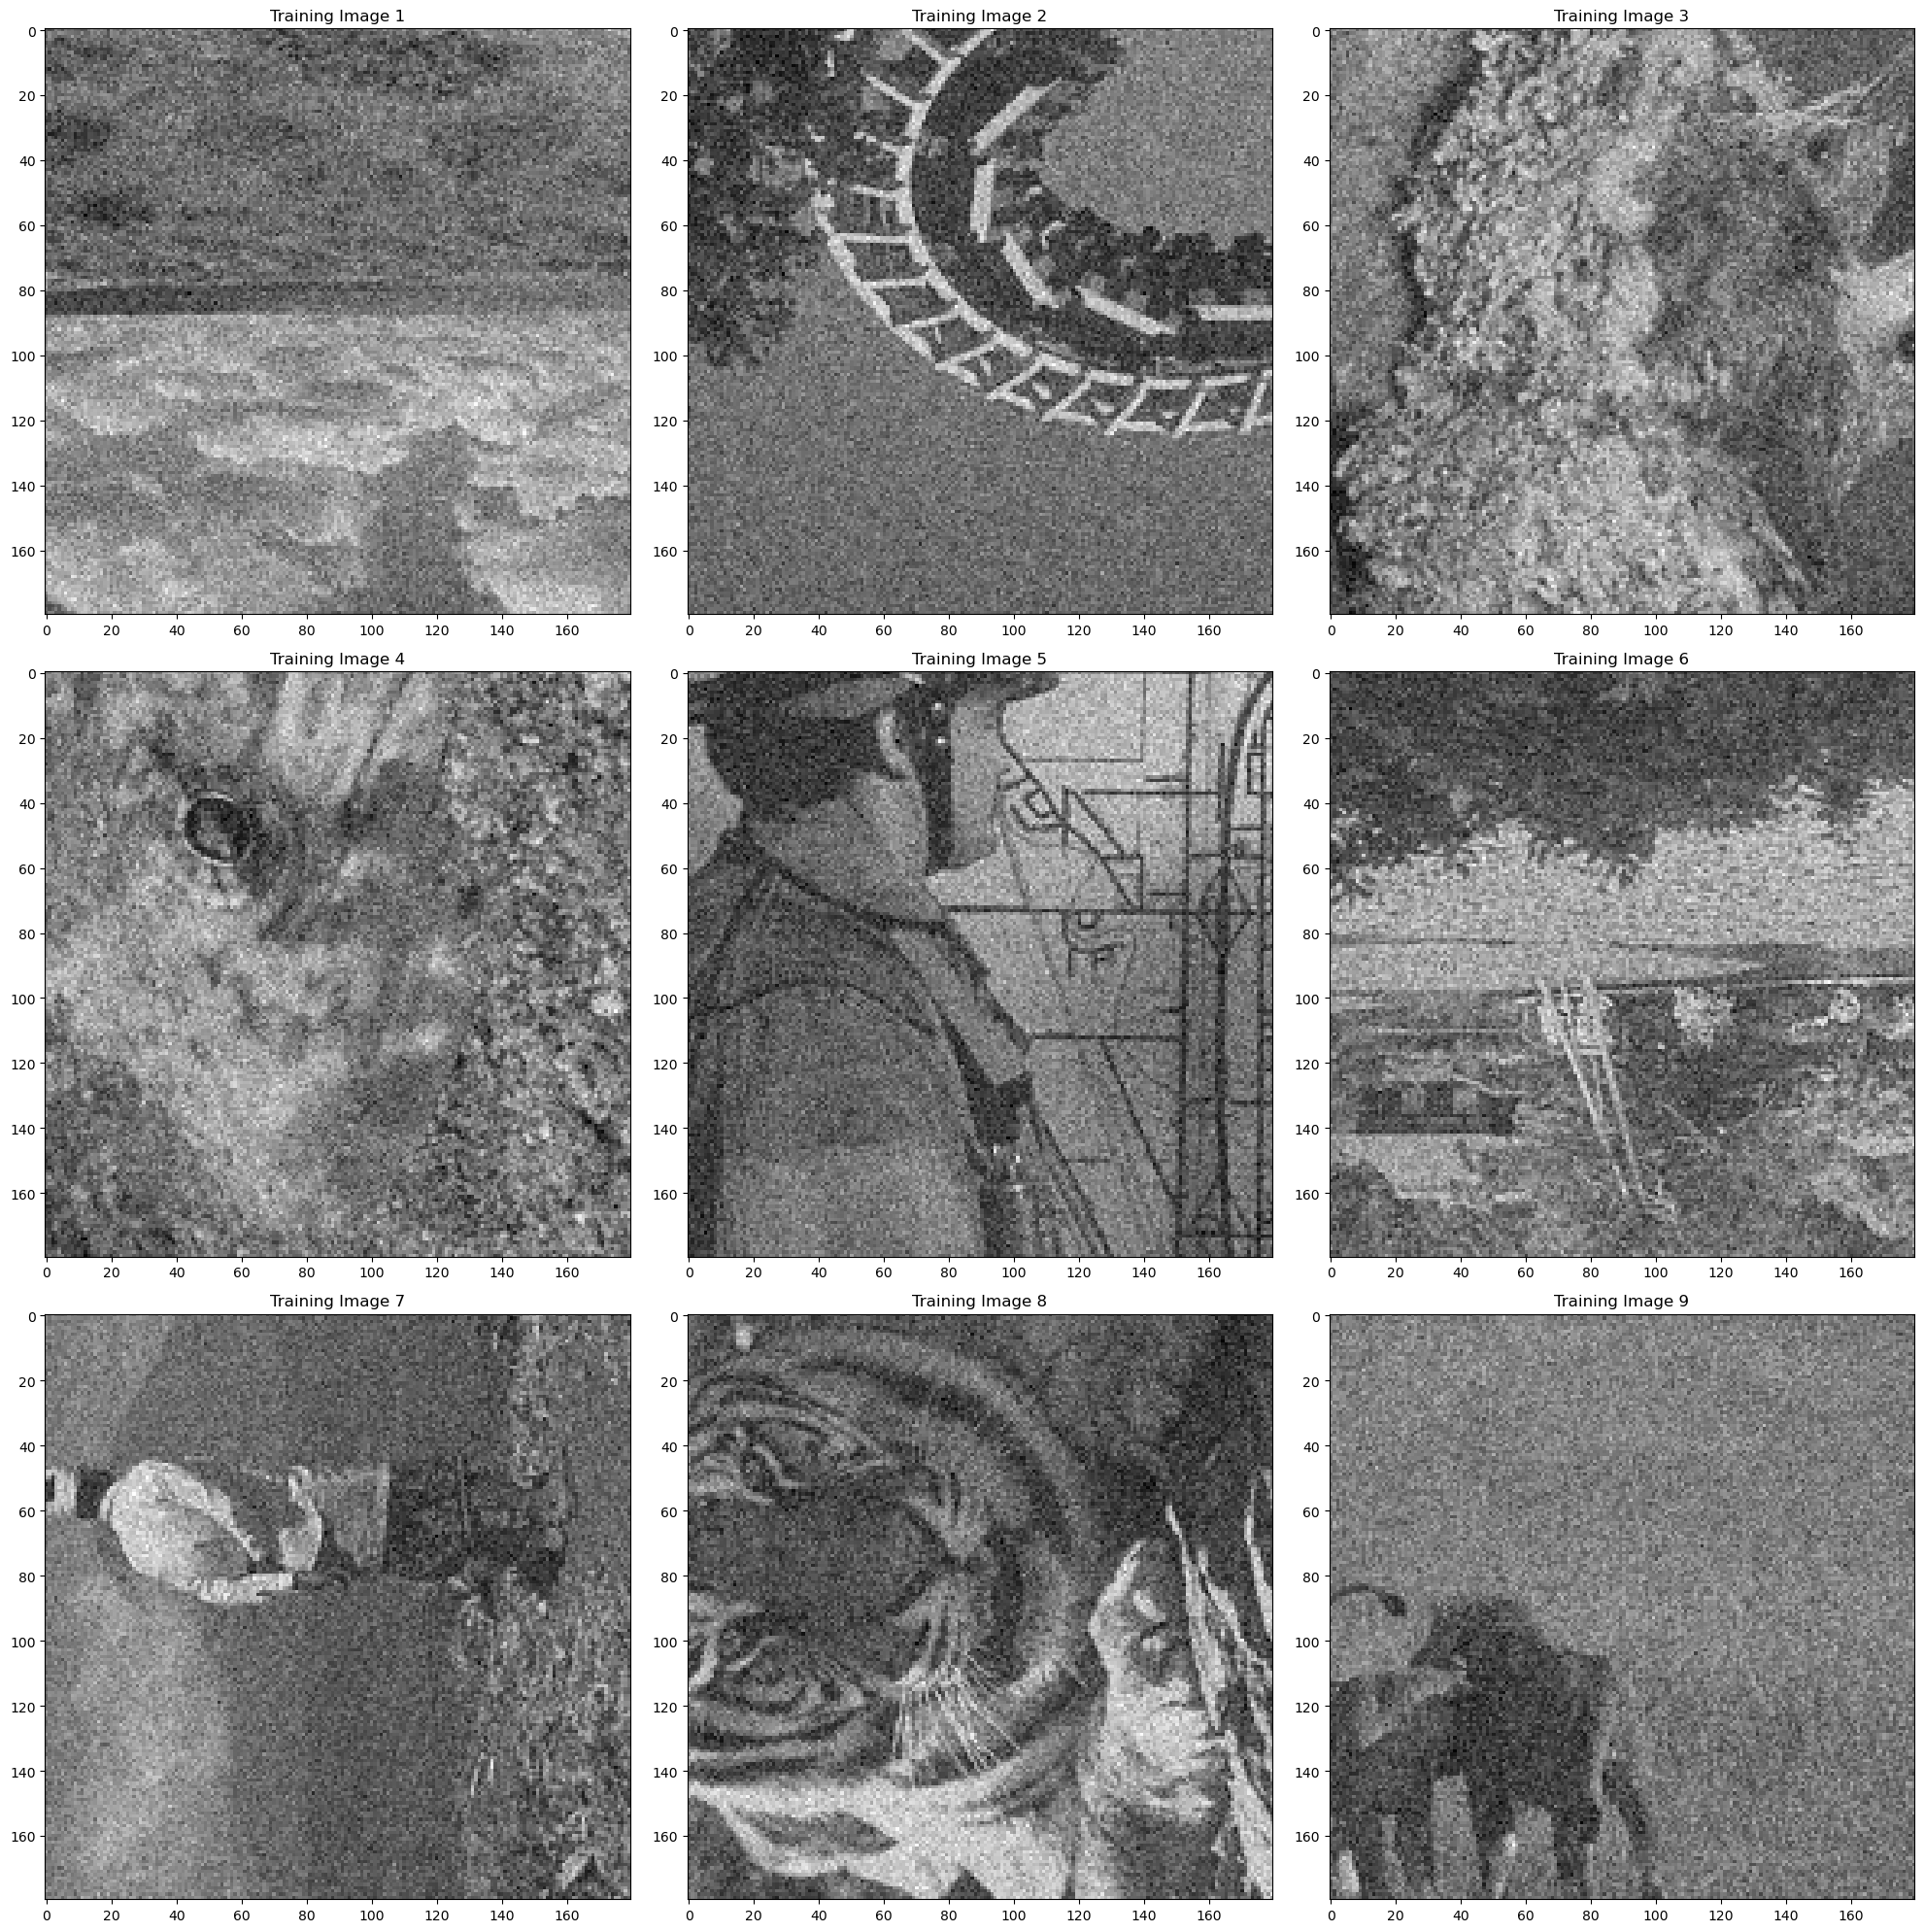

In [ ]:

train_images = tifffile.imread(next(iter(train_path.rglob("*.tiff")))) # 3168 images
val_images = tifffile.imread(next(iter(val_path.rglob("*.tiff"))))
starting_index = 1 #Change this to show different images

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(17, 17))

for ax, idx in zip(axes.flat, range(starting_index, starting_index + 16)): #Couples the axes with the indexes
    ax.imshow(train_images[idx], cmap="gray")
    ax.set_title(f"Training Image {idx}")
    
plt.tight_layout()
plt.show()


## Creazione della Configurazione di Addestramento

Prima di avviare la fase di addestramento, è necessario definire un oggetto di **configurazione** che descriva sia l’architettura della rete neurale sia le modalità di training.

Questa configurazione include i principali iperparametri che governano il processo di apprendimento. Tra i più rilevanti:

- `batch_size`: numero di immagini elaborate contemporaneamente durante un singolo passo di addestramento.
- `num_epochs`: numero di epoche, ovvero il numero di volte in cui l’intero dataset di addestramento viene utilizzato per aggiornare i pesi della rete.

La scelta di tali parametri deve essere effettuata tenendo conto delle **risorse hardware disponibili**, in particolare della memoria della GPU e del tempo di addestramento desiderato.  
Un bilanciamento adeguato tra questi valori consente di ottenere un addestramento stabile ed efficiente.

In [7]:
config = create_n2v_configuration(
    experiment_name="bsd68_n2v",
    data_type="tiff",
    axes="SYX",
    patch_size=(64, 64),
    batch_size=64,
    num_epochs=10,
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1},
                      'optimizer': {'name': 'Adam',
                                    'parameters': {'lr': 0.0001}}},
 'data_config': {'axes': 'SYX',
                 'batch_size': 64,
                 'data_type': 'tiff',
                 'patch_size': [64, 64],
                 'transforms': [{'mean': 0.485,
      

## Addestramento del Modello

L’addestramento del modello viene effettuato creando un oggetto **CAREamist**, inizializzato a partire dall’oggetto di configurazione definito in precedenza. 

Al termine del training, i **checkpoint migliori** del modello vengono salvati in file dedicati, generalmente con estensione `.ckpt`, per consentire successivi test o predizioni senza dover ripetere l’addestramento.

In [9]:
# Before proceding, make sure your GPU is available to PyTorch or the training will be very slow

careamist = CAREamist(source=config, work_dir="notebooks/models/bsd68")

# train model
print(f"Training starting now...")
careamist.train(train_source=train_path, val_source=val_path)
print("Training ended!")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training starting now...


Extracted 28512 patches from input array.
Extracted 36 patches from input array.
/home/paoloparati/anaconda3/envs/n2v/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/paoloparati/Downloads/PrincipiEModelliDellaPercezione/notebooks/models/bsd68/checkpoints exists and is not empty.

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 509 K  | train
---------------------------------------
509 K     Trainable params
0         Non-trainable params
509 K     Total params
2.037     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 446/446 [15:29<00:00,  2.08s/it, train_loss_step=0.203, val_loss=0.195, train_loss_epoch=0.208]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 446/446 [15:29<00:00,  2.08s/it, train_loss_step=0.203, val_loss=0.195, train_loss_epoch=0.208]
Training ended!


## Generazione delle Predizioni

Al termine dell’addestramento, il modello viene utilizzato per generare predizioni sulle immagini rumorose presenti nel set di **testing**.

Il metodo `.predict` sfrutta l’**ultimo checkpoint salvato** durante l’addestramento per produrre le immagini denoised.  
Nel caso del **Dataset BSD68**, il modello genera predizioni per tutte le 68 immagini del dataset.

Questa fase consente di valutare il comportamento del modello su dati non visti durante l’addestramento e di confrontare le immagini predette con le corrispondenti **Ground Truth**, fornendo una misura oggettiva delle prestazioni del denoising.

In [10]:

output_path = "notebooks/predictions/bsd68/predictions.tiff"

prediction = careamist.predict(
    source=test_path,
    axes="YX",
    tile_size=(128, 128),
    tile_overlap=(48, 48),
    batch_size=1,
)

/home/paoloparati/anaconda3/envs/n2v/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: |          | 1632/? [07:01<00:00,  3.87it/s]


## Visualizzazione delle Predizioni

A questo stadio, le predizioni generate dal modello vengono visualizzate per valutarne la qualità.  

Vengono mostrate solo **n immagini** selezionate casualmente dal dataset di test.  
Ogni immagine predetta viene confrontata con la rispettiva **Ground Truth** fornita dal dataset, consentendo di valutare in modo oggettivo le capacità del modello di rimuovere il rumore preservando i dettagli strutturali.

Questa fase permette di osservare:

- la **precisione del denoising**, ovvero quanto le predizioni si avvicinano all’immagine originale;
- le eventuali **limitazioni empiriche** dell’algoritmo N2V, come la difficoltà nel riprodurre dettagli fini o la presenza di artefatti residuali.  

La visualizzazione costituisce quindi uno strumento chiave per comprendere le prestazioni qualitative del modello.


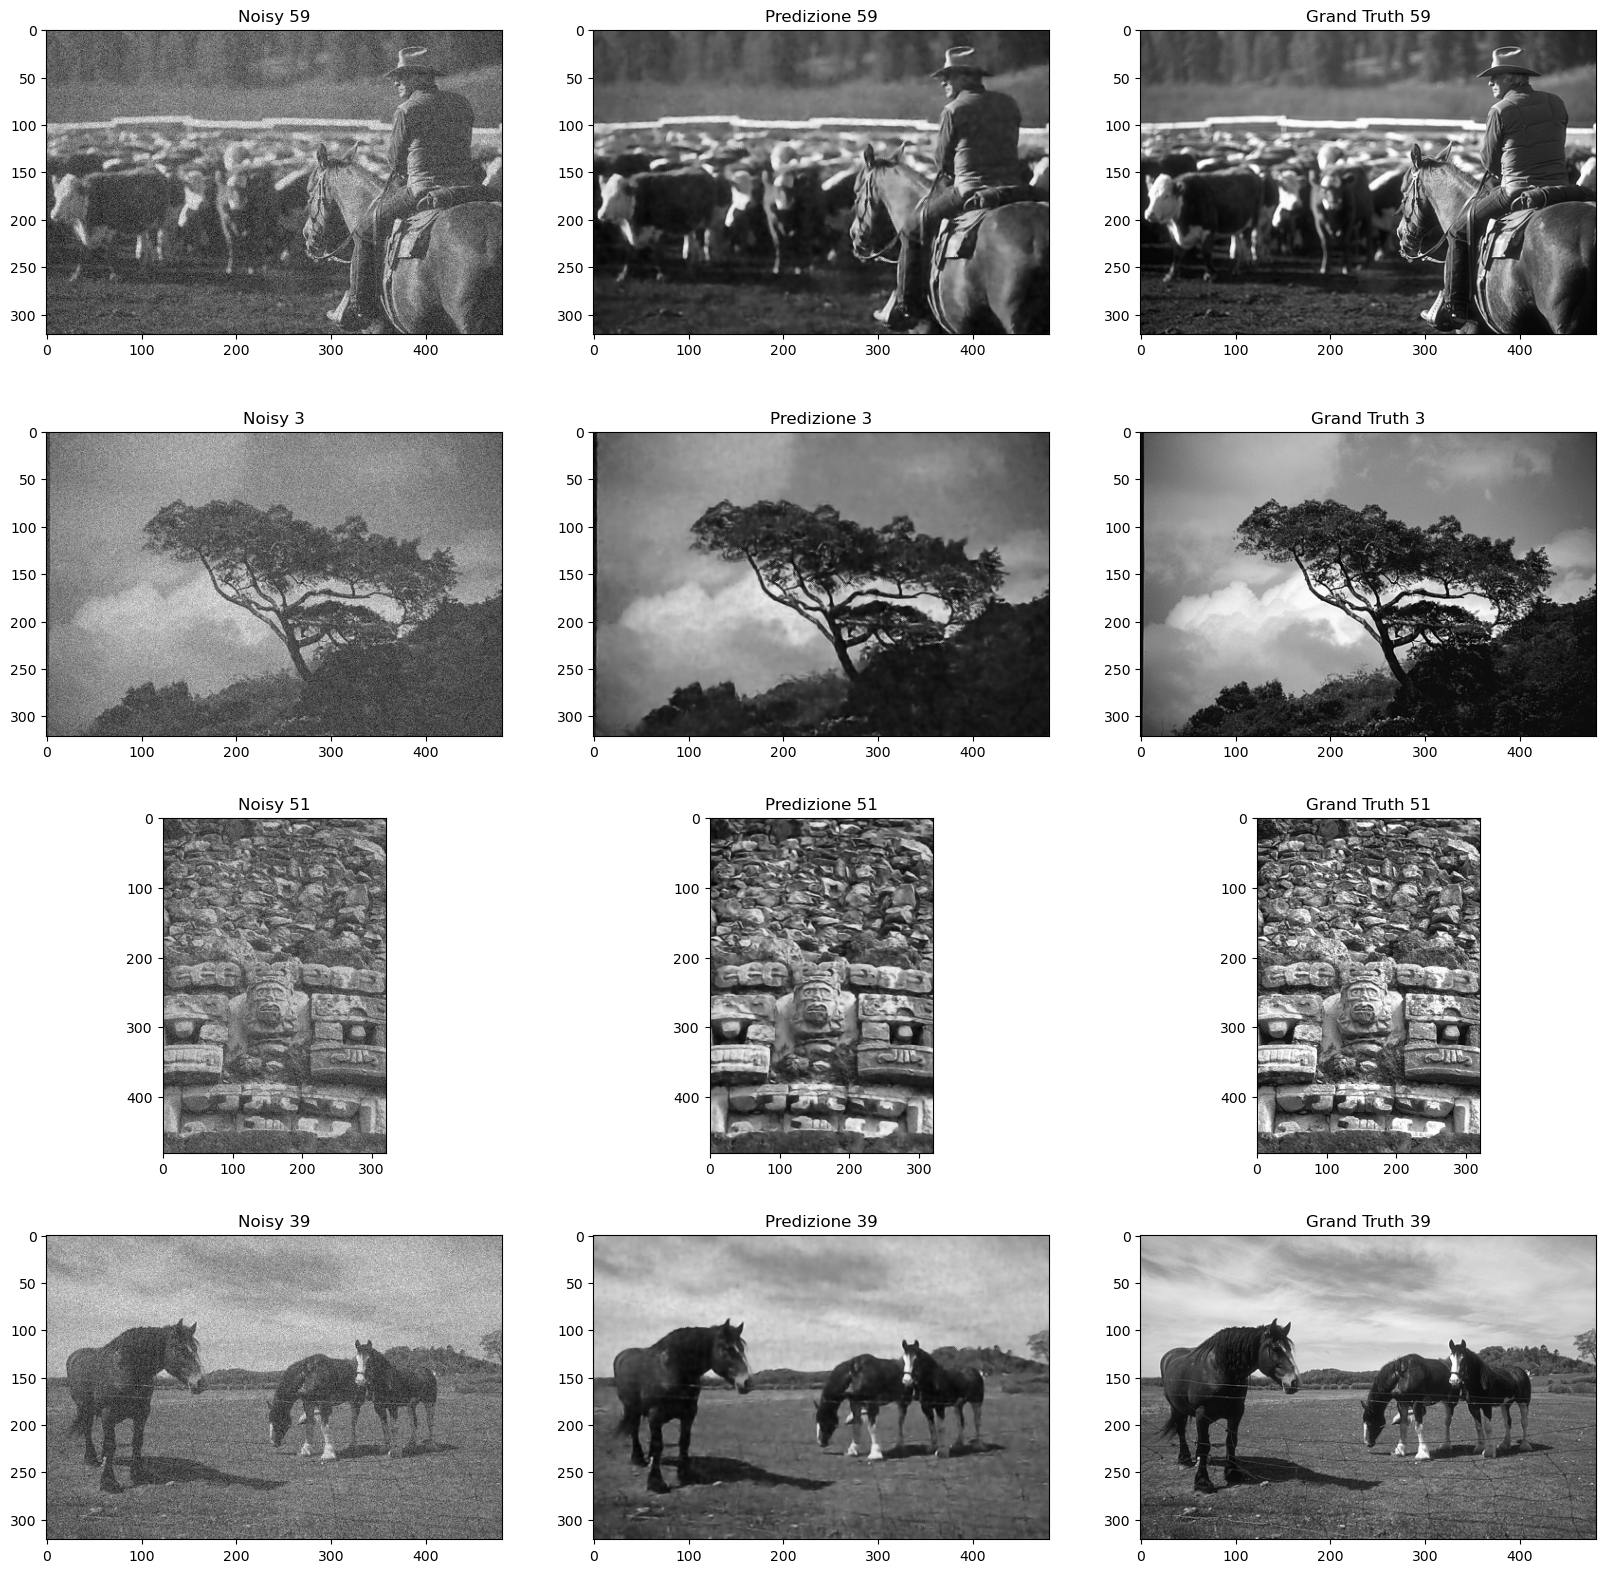

In [25]:
n = 4

test_images = [tifffile.imread(f) for f in sorted(test_path.glob("*.tiff"))]
ground_truth_images = [tifffile.imread(f) for f in sorted(gt_path.glob("*.tiff"))]

random_indexes = np.random.choice(range(len(test_images)), n)

fig, ax = plt.subplots(4, 3, figsize=(20, 20))
for a, i in zip(range(n), random_indexes):
    ax[a, 0].imshow(test_images[i], cmap="gray")
    ax[a, 0].set_title(f"Noisy {i}")
    ax[a, 1].imshow(prediction[i].squeeze(), cmap="gray")
    ax[a, 1].set_title(f"Predizione {i}")
    ax[a, 2].imshow(ground_truth_images[i], cmap="gray")
    ax[a, 2].set_title(f"Grand Truth {i}")